# 03 - Plotting GAM Functions

In notebook 01 I determined the optimal set of features and lambda parameters for age predictions, and in notebook 02, I used these to train a model and predict age in a bird-fold cross validation scheme. Now, I am going to train the model with all the birds in the dataset, and look at the relationship between each feature and age that the model learns. 

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pygam import LinearGAM, s, f
from sklearn.model_selection import LeaveOneGroupOut

## Prepare Dataset

In [3]:
path_to_feats = 'C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\'

### Load Duke Data

In [4]:
all_feats = pd.read_csv(path_to_feats + "Duke_all_features_morning.csv").drop(columns= 'Unnamed: 0')

### Load UTSW Data

In [5]:
all_feats_utsw = pd.read_csv( path_to_feats + "utsw_all_features_morning.csv").drop(columns= 'Unnamed: 0')

### Load Extra UTSW Birds

In [6]:
acoustics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\FP1_normal_morning_only\\morning_Juvenile_acoustic_features.csv').drop(columns = 'Unnamed: 0')
syntax = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\FP1_normal_morning_only\\morning_syntax_features_whisper_UMAP.csv").drop(columns = 'Unnamed: 0')
rhythm_spectrum_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\FP1_normal_morning_only\\morning_rhythm_spectrum_features.csv").drop(columns = 'Unnamed: 0')
timing_seg_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\FP1_normal_morning_only\\morning_syllable_and_gap_duration_entropies.csv").drop(columns = 'Unnamed: 0')



In [7]:
all_feats_new = pd.merge(acoustics, syntax, on =["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, rhythm_spectrum_feats, on = ["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, timing_seg_feats, on = ["Bird_ID", 'age'])
all_feats_new['colony'] = 'fp1'

In [8]:
all_feats = pd.concat([all_feats, all_feats_utsw, all_feats_new])

In [9]:
all_feats = all_feats[~all_feats.Bird_ID.isin(['S833', 'Y856', 'O833', 'notag833'])]

### Load Test set group 1

In [10]:
acoustics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_test_set_moring\\morning_Juvenile_acoustic_features.csv').drop(columns = 'Unnamed: 0')
syntax = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_test_set_moring\\morning_syntax_features_whisper_UMAP.csv").drop(columns = 'Unnamed: 0')
rhythm_spectrum_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_test_set_moring\\morning_rhythm_spectrum_features.csv").drop(columns = 'Unnamed: 0')
timing_seg_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_test_set_moring\\morning_syllable_and_gap_duration_entropies.csv").drop(columns = 'Unnamed: 0')


In [11]:
all_feats_new = pd.merge(acoustics, syntax, on =["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, rhythm_spectrum_feats, on = ["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, timing_seg_feats, on = ["Bird_ID", 'age'])
all_feats_new['colony'] = 'test'

In [12]:
all_feats_new.shape

(44, 60)

In [13]:
all_feats = pd.concat([all_feats, all_feats_new])

### Load Test set group 2

In [14]:
acoustics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_birds_features\\morning_only\\test_morning_Juvenile_acoustic_features.csv').drop(columns = 'Unnamed: 0')
syntax = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_birds_features\\morning_only\\test_morning_syntax_features_whisper_UMAP.csv").drop(columns = 'Unnamed: 0')
rhythm_spectrum_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_birds_features\\morning_only\\test_morning_rhythm_spectrum_features.csv").drop(columns = 'Unnamed: 0')
timing_seg_feats = pd.read_csv("C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\Juvenile_bird_analysis\\utsw_birds_features\\morning_only\\test_morning_syllable_and_gap_duration_entropies.csv").drop(columns = 'Unnamed: 0')



In [15]:
all_feats_new = pd.merge(acoustics, syntax, on =["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, rhythm_spectrum_feats, on = ["Bird_ID", 'age'])
all_feats_new = pd.merge(all_feats_new, timing_seg_feats, on = ["Bird_ID", 'age'])
all_feats_new['colony'] = 'test'

In [16]:
all_feats_new.shape

(16, 60)

In [17]:
all_feats = pd.concat([all_feats, all_feats_new])

In [18]:
all_feats.shape

(103, 60)

### Drop Amplitude Features

In [19]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

### Normalize Feature Set

In [20]:
full_feats_only = np.array(all_feats.drop(columns = ['Bird_ID', 'age', 'entropy_rate', 'colony', 'num_syllables']))

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
full_feats_only_norm = scaler.fit_transform(full_feats_only)
y = all_feats.age


In [22]:
y = np.array(y).flatten()

## Fit Model

In [23]:
#this is taken from notebook 1 where we did forward feature selection
selected_feature_indices = [41, 36, 19, 33, 16, 24, 34]

In [24]:
feature_list = all_feats.drop(columns = ['Bird_ID', 'age', 'entropy_rate', 'colony', 'num_syllables']).columns.to_list()
[feature_list[x] for x in selected_feature_indices]

['syllable_duration_entropy',
 'entropy_rate_norm',
 'Goodness_CV_min',
 'duration_CV_median',
 'duration_mean_min',
 'Entropy_CV_median',
 'duration_CV_min']

In [25]:
terms = s(selected_feature_indices[0], lam = 10) + s(selected_feature_indices[1], lam = 10) + \
        s(selected_feature_indices[2], lam = 10) + s(selected_feature_indices[3], lam = 10) + \
        s(selected_feature_indices[4], lam = 10) + s(selected_feature_indices[5], lam = 10) + \
        s(selected_feature_indices[6], lam = 10) 

gam = LinearGAM(terms)

gam.fit(full_feats_only_norm, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(41) + s(36) + s(19) + s(33) + s(16) + s(24) + s(34) + intercept,
   tol=0.0001, verbose=False)

In [26]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.6626
Link Function:                     IdentityLink Log Likelihood:                                  -538.4198
Number of Samples:                          103 AIC:                                             1102.1647
                                                AICc:                                            1106.0377
                                                GCV:                                               92.5228
                                                Scale:                                             73.8796
                                                Pseudo R-Squared:                                   0.7109
Feature Function                  Lam

c:\Users\tkoch\anaconda3\envs\pyGAM_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [27]:
i = 0

In [33]:
intercept = gam.coef_[-1]
intercept

40.91540034058265

In [45]:
titles = ['Syllable Duration Entropy', 'Syntax Entropy Rate', 'Minimum Goodness of Pitch CV', 
          'Median Syllable Duration CV', 'Minimum Mean Syllable Duration', 'Median Weiner Entropy CV', 
          'Minimum Syllable Duration CV']

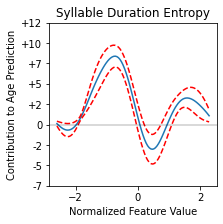

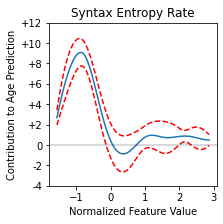

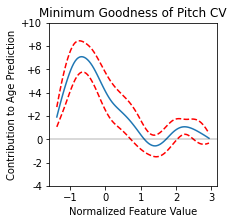

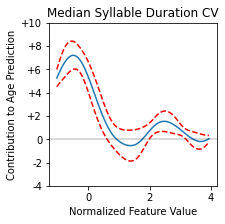

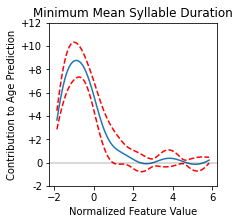

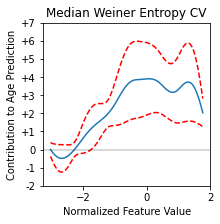

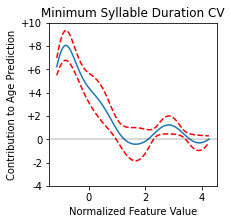

In [48]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term = i)
    pdep, confi = gam.partial_dependence(term = i, X = XX, width = 0.95)

    plt.figure(figsize=(3, 3))
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(titles[i])
    plt.xlabel('Normalized Feature Value')
    plt.ylabel('Contribution to Age Prediction')
    plt.axhline(y =  0, color = 'black', alpha = 0.2,)

    # Set the y-tick labels with '+' for positive numbers, '-' is default for negative
    current_yticks = plt.yticks()[0]

    # Set y-tick labels with '+' for positive, '-' is default for negative
    plt.yticks(current_yticks, [f'+{int(tick)}' if tick > 0 else f'{int(tick)}' for tick in current_yticks])
    plt.show()